# PEP = Prompt Embedding Probe 

At this experiment we will use Prompt Embedding Prome (PEP) model for prediction answer correctness.

PEP is quite similar to linear probes such as linear probes from Semantic Entropy Probes (SEP) paper.

Main difference is additional use of trainable prompt embedding which get through model layer by layer and then as well as in SEP linear probe applied to chosen transformer layer output.

At that framework we support any position for applying PEP. By the way, how to apply PEP?

Imagine, LLM are generating answer. We can apply PEP at the any moment. We just stop generation, make one forward pass with additional prompt embedding, probe hidden state and get prediction. At that framework 2 modes of position choice are implemented: TBG-like and SLT-like setups. In TBG-like we set pos at positive integer and will interrupt generation for the one forward pass with callback function invokation. In SLT-like setup we first generate full sequence and than count pos times from the end and apply PEP to truncated sequence. At that case we use negative integer for a position definition.

So here I will try show how does PEP method works.

### Imports and configs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [3]:
# Internal imports
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.config.loader import ExperimentConfig
from src.dataset import BaseDataset
from src.scoring.prompt_embedding import PEPModel
from src.model import MistralModel
from src.training import PEPTrainer, plot_history_grid

In [4]:
config_path = '../configs/examples/pep_triviaqa_load_enriched.toml'
config = ExperimentConfig.from_toml(config_path)
print(config._config)

{'experiment': {'name': 'pep_triviaqa_example', 'output_dir': 'exp_results/pep_example', 'seed': 42}, 'dataset': {'enriched_path': 'exp_results/enrich_triviaqa/enriched_datasets'}, 'model': {'model_type': 'mistral-7b-instruct', 'model_name_or_path': 'mistralai/Mistral-7B-Instruct-v0.1', 'system_prompt': 'Answer briefly.', 'quantization': '8bit', 'device_map': 'auto', 'evaluator': 'substring_match'}, 'probe': {'probe_type': 'pep'}, 'training': {'layers': [0, 8, 16, 24, 31], 'positions': [0, -2], 'targets': ['is_correct'], 'use_cv': False, 'pep_params': {'n_embeddings': 1, 'learning_rate': 0.001, 'n_epochs': 10, 'batch_size': 16, 'weight_decay': 0.0, 'optimizer': 'adam', 'early_stopping_patience': 5, 'early_stopping_metric': 'auc', 'val_check_interval': 10, 'return_history': True, 'save_best_model': True, 'n_samples_for_train': 1000, 'max_training_time': 3600}}}


### Data loading

You can obtain dataset with eun src/experiment_runner.py with configs/data/enrich_triviaqa.toml. Command can be as follow

!python3 -m src.experiment_runner configs/data/enrich_triviaqa.toml

You can specify parameters like n_samples, layers, positions in config and also specify output directory.

That script run for about 20 h with 3060 with that parametes.

After it we will get dataset with the fields that you can find at DatasetSample in src/dataset/base. Actually, you can skip the longest part of data enrichment - semantic_entropy enrichment by deleting corresponding section in config if you do not are coing to use SE as target in probe training.

In [5]:
train_data = BaseDataset.load("../" + config.dataset['enriched_path'] + '/train.pkl')
val_data = BaseDataset.load("../" + config.dataset['enriched_path'] + '/val.pkl')
test_data = BaseDataset.load("../" + config.dataset['enriched_path'] + '/test.pkl')

In [6]:
print(f'Len of train: {len(train_data)}, len of val: {len(val_data)}, len of test: {len(test_data)}')
sample = train_data[0]
print(f'One sample keys: {sample.keys()}')
print(f'Question (prompt): {sample['prompt']}')
print(f'GT answers (frist 3): {sample['gt_answers'][:3]}')
print(f'Greedy answer: {sample['greedy_answer']}')
print(f'Is correct: {sample['is_correct']}')
print(f'Sampled answers: {sample['sampling_answers']}')
print(f'Semantic entropy clusters: {sample['semantic_ids']}')
print(f'Semantic entropy raw: {sample['se_raw']}')
print(f'Semantic entropy binarized: {sample['se_binary']}')
print(f'Semantic_entropy threshold: {sample['se_gamma']}')
print(f'Semantic_entropy weight: {sample['se_weight']}')
print(f'Activations pos: {sample['activations']['positions']}')
print(f'Activations layers: {sample['activations']['layers']}')
print(f'One activation: {sample['activations']['acts'][0][16].shape}')

Len of train: 3500, len of val: 500, len of test: 1000
One sample keys: dict_keys(['prompt', 'gt_answers', 'greedy_answer', 'is_correct', 'activations', 'sampling_answers', 'se_raw', 'semantic_ids', 'se_gamma', 'se_binary', 'se_weight'])
Question (prompt): The peptide hormone renin is secreted by which organ of the body?
GT answers (frist 3): ['interstitial kidney cells', 'renal', 'nephrous']
Greedy answer: The kidneys.
Is correct: 1.0
Sampled answers: ['Renin is secreted by the kidneys.', 'The kidneys.', 'Renin is secreted by the kidneys.', 'Kidney', 'Renin is secreted by the kidneys.', 'The kidneys.', 'The kidney.', 'Renin is secreted by the juxtaglomerular cells (JGCs) of', 'Kidney.', 'Renin is secreted by the kidneys.']
Semantic entropy clusters: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Semantic entropy raw: 0.3221571719530561
Semantic entropy binarized: 0
Semantic_entropy threshold: 0.8345048017599515
Semantic_entropy weight: 1.0850172935039986
Activations pos: [0, -2]
Activations layers: [

### Base model loading

In [7]:
quant_type = config.model['quantization']
if quant_type == '8bit':
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
elif quant_type == '4bit':
    quant_config = BitsAndBytesConfig(load_in_4bit=True)

model_name = config.model['model_name_or_path'] 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=config.model.get('device_map', 'auto'),
    quantization_config=quant_config
)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
if hasattr(model, 'generation_config'):
    model.generation_config.pad_token_id = tokenizer.pad_token_id

# Create wrapper
model_type = config.model['model_type']  # No fallback, validated
system_prompt = config.model.get('system_prompt', '', warn_on_fallback=True)
model_wrapper = MistralModel(
    model=model,
    tokenizer=tokenizer,
    system_prompt=system_prompt
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Pep model

In [8]:
pep_model = PEPModel(
    model_wrapper,
    n_embeddings=1,
    probe_layer=16,
    probe_position=-2,
    probe_type='accuracy'  # Scoring will be output 1 if answer is high propable wrong
)

PEP model contains weights for prompt_embeddings and linear probe. Main methods forward implements appending to the end of sequence prompt embeddings and linear probe after inner forward call of model. Inference of model will be viewed later. 

In [9]:
shape = (8, 16)  # batch, seqlen
random_batched_input = torch.randint(0, model_wrapper.model.config.vocab_size, (shape)).to(device)
output = pep_model(random_batched_input, return_activations=False)
print(output.shape)  # Get predicts

torch.Size([8, 1])


### Train PEP (for one position and layer)

We will use PEPTrainer from src/training module

In [10]:
pep_params = config.training['pep_params'] 
config.training

{'layers': [0, 8, 16, 24, 31],
 'positions': [0, -2],
 'targets': ['is_correct'],
 'use_cv': False,
 'pep_params': {'n_embeddings': 1,
  'learning_rate': 0.001,
  'n_epochs': 10,
  'batch_size': 16,
  'weight_decay': 0.0,
  'optimizer': 'adam',
  'early_stopping_patience': 5,
  'early_stopping_metric': 'auc',
  'val_check_interval': 10,
  'return_history': True,
  'save_best_model': True,
  'n_samples_for_train': 1000,
  'max_training_time': 3600}}

In [11]:
trainer = PEPTrainer(
    model_wrapper, 
    learning_rate=pep_params['learning_rate'],
    n_epochs=pep_params['n_epochs'],
    batch_size=pep_params['batch_size'],
    weight_decay=pep_params['weight_decay'],
    optimizer_type='adamw',
    device=device,
    early_stopping_patience=10,
    max_samples=20000,
    max_training_time=3600,
    val_check_interval=50,
    val_samples=250
)

In [12]:
pep_model, training_info = trainer.fit(train_data, 'is_correct', val_dataset=val_data, return_history=True, create_new_model=False, model=pep_model)

Epoch 6/6:  71%|███████   | 155/219 [07:10<02:57,  2.78s/it]


In [16]:
test_preds = trainer.predict(
    pep_model, test_data, None, None,
    add_to_dataset=False
)

In [14]:
test_targets = np.array([s[config.training['targets'][0]] for s in test_data])
test_auc = roc_auc_score(test_targets, 1 - test_preds)
print(f'Result test auc: {test_auc}')

Result test auc: 0.7801680208219135


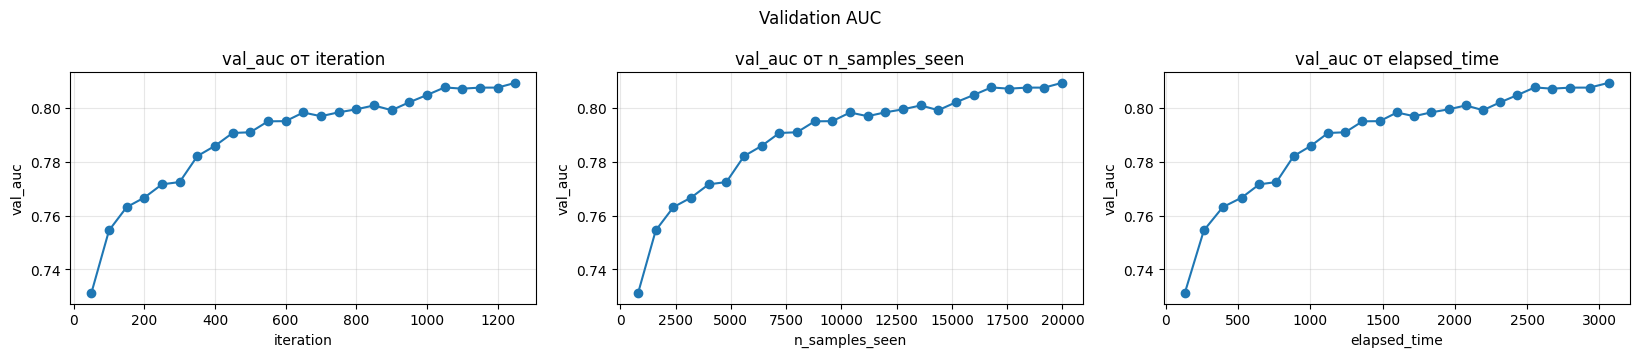

In [17]:
fig, axes = plot_history_grid(
    training_info["history"],
    x_list=["iteration", "n_samples_seen", "elapsed_time"],
    y_list=["val_auc"],
    ncols=3,
    suptitle="Validation AUC"
)
plt.show()